# Node Classification

In this notebook we consider the problem of node classification for the NDSSL data. We will predict the worker attribute (which is 0 for unemployed and 1 for employed) with 3 different models:
- Multi-Layer Perceptron (MLP)
- Graph Convolutional Network (GCN)
- GraphSAGE

The results of this notebook are used in Sec. 5.1 of the report.

In [ ]:
from imports import *
from nodepred import *
from dataset import *

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style as style 
style.use('seaborn-paper')
%matplotlib inline

fontsize = 12
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

In [2]:
## set random seeds
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [3]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

1.5.1
device = cuda


## Load the Dataset

In [4]:
node_attributes = pd.read_csv('data/NDSSL data/raw/node_attributes.csv')
node_attributes.head(5)

,person_id,household_id,age,gender,worker,relationship,household_income,household_size,zipcode,household_vehicles,household_workers
0,2509159,2201175,42,1,1,1,13,3,97201,3,2
1,2509160,2201175,43,2,1,1,13,3,97201,3,2
2,2509161,2201175,17,1,2,2,13,3,97201,3,2
3,2509162,2201176,41,1,1,1,11,2,97201,3,1
4,2509163,2201176,11,1,2,2,11,2,97201,3,1


In [5]:
## remove old processed files
import os, shutil
if os.path.exists('data/NDSSL data/processed'):
    shutil.rmtree('data/NDSSL data/processed')

dataset = load_dataset(dataset_name='NDSSL')
data = dataset[0]
dataset.process()

Processing...
{'x': None, 'edge_index': tensor([[      0,       0,       1,  ..., 1486224, 1378614, 1556530],
        [      1,       2,       2,  ..., 1601329, 1601329, 1601329]]), 'edge_attr': None, 'y': None, 'pos': None, 'norm': None, 'face': None, 'edge_weight': tensor([10.9161, 12.7494, 12.5828,  ...,  0.0497,  0.1667,  0.1667])}
Done!
{'x': None, 'edge_index': tensor([[      0,       0,       1,  ..., 1486224, 1378614, 1556530],
        [      1,       2,       2,  ..., 1601329, 1601329, 1601329]]), 'edge_attr': None, 'y': None, 'pos': None, 'norm': None, 'face': None, 'edge_weight': tensor([10.9161, 12.7494, 12.5828,  ...,  0.0497,  0.1667,  0.1667])}


In [6]:
data_columns = ['age', 'gender', 'zipcode', 'relationship',  
                'household_workers', 'household_income', 'household_size', 'household_vehicles']
data.x = dataframe2onehot(node_attributes[data_columns], node_attributes)
data.x.shape

torch.Size([1601330, 141])

In [7]:
np.unique(node_attributes['worker'].values)

array([1, 2])

In [8]:
data.y = torch.LongTensor(node_attributes['worker'].values - 1)
data.y = data.y.type(torch.int64).reshape((len(node_attributes), 1))[:,0]
data.y.shape

torch.Size([1601330])

In [9]:
data.y[0:20]

tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1])

In [10]:
num_classes = len(torch.unique(data.y))
num_classes

2

Make the train/val/test split. We could pick random subsets of the nodes, or make the split by household.

In [11]:
split_by_household = True

if not split_by_household:
    ## create a train/val/test split
    node_ids = list(set(list(node_attributes['person_id'])))
    np.random.shuffle(node_ids)

    ntrain = int(0.8 * len(node_ids))
    nval = len(node_ids) - ntrain #int(0.2 * len(household_ids))
    ntest = len(node_ids) - (ntrain + nval)

    node_ids_train = node_ids[:ntrain]
    node_ids_val = node_ids[ntrain:ntrain + nval]
    node_ids_test = node_ids[ntrain + nval:]

    train_mask = torch.IntTensor(node_attributes['person_id'].isin(node_ids_train)).type(torch.int64)
    val_mask = torch.IntTensor(node_attributes['person_id'].isin(node_ids_val)).type(torch.int64)
    test_mask = torch.IntTensor(node_attributes['person_id'].isin(node_ids_test)).type(torch.int64)

    train_idx = np.arange(len(node_attributes))[train_mask == 1]
    val_idx = np.arange(len(node_attributes))[val_mask == 1]
    test_idx = np.arange(len(node_attributes))[test_mask == 1]

    print('size of training set: %i' %torch.sum(train_mask).item())
    print('size of validation set: %i' %torch.sum(val_mask).item())
    print('size of testing set: %i' %torch.sum(test_mask).item())
else:
    ## create a train/val/test split by household
    household_ids = list(set(list(node_attributes['household_id'])))
    np.random.shuffle(household_ids)

    ntrain_households = int(0.8 * len(household_ids))
    nval_households = len(household_ids) - ntrain_households #int(0.2 * len(household_ids))
    ntest_households = len(household_ids) - (ntrain_households + nval_households)

    households_train = household_ids[:ntrain_households]
    households_val = household_ids[ntrain_households:ntrain_households + nval_households]
    households_test = household_ids[ntrain_households + nval_households:]

    print('number of distinct households: %i' %len(household_ids))
    print('number of training households: %i' %len(households_train))
    print('number of validation households: %i' %len(households_val))
    print('number of testing households: %i' %len(households_test))

    train_mask = torch.IntTensor(node_attributes['household_id'].isin(households_train)).type(torch.bool)
    val_mask = torch.IntTensor(node_attributes['household_id'].isin(households_val)).type(torch.bool)
    test_mask = torch.IntTensor(node_attributes['household_id'].isin(households_test)).type(torch.bool)

    train_idx = np.arange(len(node_attributes))[train_mask == 1]
    val_idx = np.arange(len(node_attributes))[val_mask == 1]
    test_idx = np.arange(len(node_attributes))[test_mask == 1]

    print('size of training set: %i' %torch.sum(train_mask).item())
    print('size of validation set: %i' %torch.sum(val_mask).item())
    print('size of testing set: %i' %torch.sum(test_mask).item())

number of distinct households: 632626
number of training households: 506100
number of validation households: 126526
number of testing households: 0
size of training set: 1280901
size of validation set: 320429
size of testing set: 0


In [12]:
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

Break down the number of edges by train/test:

In [13]:
edge_tuple_list = tuple(map(tuple, np.transpose(data.edge_index.numpy())))
edge_tuple_array = np.asarray(edge_tuple_list)

edge_idx_train0 = np.isin(edge_tuple_array[:,0], train_idx)
edge_idx_train1 = np.isin(edge_tuple_array[:,1], train_idx)

Num_edges_train_train = np.sum(edge_idx_train0 & edge_idx_train1)
Num_edges_test_test = np.sum(~edge_idx_train0 & ~edge_idx_train1)
Num_edges_train_test = np.sum(~edge_idx_train0 & edge_idx_train1) \
                        + np.sum(edge_idx_train0 & ~edge_idx_train1)

print('check:', edge_idx_train1.shape[0] \
      == (Num_edges_train_train + Num_edges_test_test + Num_edges_train_test))

print('fraction of train-train edges: %.3f' % (Num_edges_train_train/data.edge_index.shape[1]))
print('fraction of train-test edges: %.3f' % (Num_edges_train_test/data.edge_index.shape[1]))
print('fraction of test-test edges: %.3f' % (Num_edges_test_test/data.edge_index.shape[1]))

check: True
fraction of train-train edges: 0.65
fraction of train-test edges: 0.31
fraction of test-test edges: 0.05


In [14]:
batch_size = 10000
n_epochs = 50

## Node classification: MLP 

In [15]:
full_set = torch.utils.data.TensorDataset(data.x, data.y)
train_set = torch.utils.data.Subset(full_set, train_idx)
val_set = torch.utils.data.Subset(full_set, val_idx)
#test_set = torch.utils.data.Subset(full_set, test_idx)

In [16]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [17]:
h = 256
print('number of hidden units = %i' %h)

model = mlp(data.x.shape[1], h, num_classes).to(device)
print('number of trainable parameters %i' %model_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

number of hidden units = 256
number of trainable parameters 168450


In [18]:
def train():
    model.train()

    total_loss = total_examples = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        out = model(x_batch)
        loss = F.nll_loss(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.shape[0]
        total_examples += x_batch.shape[0]
    
    return total_loss/total_examples

@torch.no_grad()
def evaluator(data_loader):
    model.eval()
    
    y_target = torch.empty(0)
    y_pred = torch.empty(0)
    loss = total_examples = 0.0
    for x_batch, y_batch in data_loader:
        x_batch,  y_batch = x_batch.to(device), y_batch.to(device)
        total_examples += x_batch.shape[0]
        
        z = model(x_batch)
        pred = 1.0*torch.argmax(nn.Softmax(dim=1)(z), axis=1).cpu()
        loss += F.nll_loss(z, y_batch).item() * x_batch.shape[0]

        y_target = torch.cat((y_target, 1.0 * y_batch.cpu()), 0)
        y_pred = torch.cat((y_pred, pred), 0)
        
    y_target = y_target.numpy()
    y_pred = y_pred.numpy()
    
    return loss/total_examples, y_target, y_pred

In [19]:
loss_train_mlp = []
acc_train_mlp = []
auc_train_mlp = []
ap_train_mlp = []
loss_val_mlp = []
acc_val_mlp = []
auc_val_mlp = []
ap_val_mlp = []

for epoch in range(n_epochs+1):

    # evaluate on both train and val sets
    loss_train, y_target_train, y_pred_train = evaluator(train_loader)    
    loss_val, y_target_val, y_pred_val = evaluator(val_loader)
    
    if epoch == 0:
        print('train batch length: %i, val batch length: %i' %(len(y_pred_train), len(y_pred_val)))
    
    # compute the accuracy, average precision, AUC
    acc_train = np.mean(y_pred_train == y_target_train)
    auc_train = roc_auc_score(y_target_train, y_pred_train)
    ap_train = average_precision_score(y_target_train, y_pred_train)
    roc_train = roc_curve(y_target_train, y_pred_train)

    acc_val = np.mean(y_pred_val == y_target_val)
    auc_val = roc_auc_score(y_target_val, y_pred_val)
    ap_val = average_precision_score(y_target_val, y_pred_val)
    roc_val = roc_curve(y_target_val, y_pred_val)

    # record the results
    loss_train_mlp.append(loss_train)
    acc_train_mlp.append(acc_train)
    auc_train_mlp.append(auc_train)
    ap_train_mlp.append(ap_train)
    
    loss_val_mlp.append(loss_val)
    acc_val_mlp.append(acc_val)
    auc_val_mlp.append(auc_val)
    ap_val_mlp.append(ap_val)

    # print results
    print('epoch: %i||train loss: %.4f||val loss: %.4f||train acc: %.4f||val acc: %.4f||train auc: %.4f||val auc: %.4f' \
          % (epoch, loss_train, loss_val, acc_train, acc_val, auc_train, auc_val))
    #print('epoch: %i||train loss: %.4f||val loss: %.4f||train acc: %.4f||val acc: %.4f' \
    #      % (epoch, loss_train, loss_val, acc_train, acc_val))
    
    # train
    if epoch != n_epochs:
        loss_train = train()


train batch length: 1280901, val batch length: 320429
epoch: 0||train loss: 0.6900||val loss: 0.6902||train acc: 0.5035||val acc: 0.5025||train auc: 0.5000||val auc: 0.5000
epoch: 1||train loss: 0.1913||val loss: 0.1910||train acc: 0.9263||val acc: 0.9259||train auc: 0.9261||val auc: 0.9258
epoch: 2||train loss: 0.1584||val loss: 0.1586||train acc: 0.9340||val acc: 0.9331||train auc: 0.9339||val auc: 0.9331
epoch: 3||train loss: 0.1475||val loss: 0.1480||train acc: 0.9361||val acc: 0.9353||train auc: 0.9360||val auc: 0.9352
epoch: 4||train loss: 0.1434||val loss: 0.1442||train acc: 0.9374||val acc: 0.9365||train auc: 0.9373||val auc: 0.9365
epoch: 5||train loss: 0.1380||val loss: 0.1395||train acc: 0.9391||val acc: 0.9381||train auc: 0.9391||val auc: 0.9380
epoch: 6||train loss: 0.1364||val loss: 0.1379||train acc: 0.9407||val acc: 0.9394||train auc: 0.9406||val auc: 0.9393
epoch: 7||train loss: 0.1329||val loss: 0.1347||train acc: 0.9422||val acc: 0.9411||train auc: 0.9421||val auc: 0

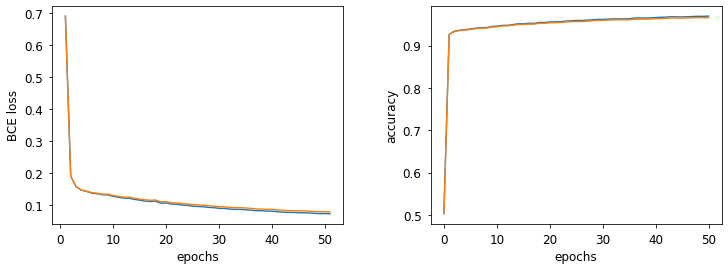

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=0.3)

ax[0].plot(np.arange(1, len(loss_train_mlp)+1), loss_train_mlp)
ax[0].plot(np.arange(1, len(loss_val_mlp)+1), loss_val_mlp)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('BCE loss')
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_ylim([np.min(loss_mlp), np.max(loss_mlp)])

ax[1].plot(acc_train_mlp)
ax[1].plot(acc_val_mlp)
#ax[1].plot(ap_mlp, label='AP')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
#ax[1].set_xscale('log')
#ax[1].legend()

#plt.savefig("figures/node_prediction_mlp.pdf", bbox_inches='tight')
plt.show()

## Node classification: Graph Neural Networks

In [21]:
# set the number of steps to match what was used for the MLP
walk_length = 100
num_steps = 10

loader = GraphSAINTRandomWalkSampler(data, batch_size=batch_size, walk_length=walk_length,
                                     num_steps=num_steps, sample_coverage=100, save_dir=None)

Compute GraphSAINT normalization: : 165000372it [01:43, 1588527.13it/s]                             


Adjust the number of epochs so that in both the MLP and GNN approaches roughly the same number of samples are visited during training.

In [22]:
mlp_epoch_size = 0
for batch in train_loader:
    mlp_epoch_size += batch[1].size()[0]
    
gnn_epoch_size = 0
for batch in loader:
    gnn_epoch_size += batch.y[batch.train_mask].size()[0]

In [23]:
n_epochs = int((mlp_epoch_size/gnn_epoch_size)*n_epochs)
n_epochs

67

### GCN

documentation: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=GCNConv#torch_geometric.nn.conv.GCNConv

In [24]:
h = 256
print('number of hidden units = %i' %h)

model = GCN(data.x.shape[1], h, num_classes).to(device)
model.set_aggr('mean')
print('number of trainable parameters %i' %model_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

number of hidden units = 256
number of trainable parameters 168450


In [25]:
def train():
    model.train()

    total_loss = total_examples = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        batch_size = out[batch.train_mask].shape[0]
        loss = F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_size
        total_examples += batch_size
    return total_loss / total_examples

@torch.no_grad()
def evaluator_train():
    model.eval()
    
    y_target = torch.empty(0)
    y_pred = torch.empty(0)
    total_loss = total_examples = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        batch_size = out[batch.train_mask].shape[0]
        total_examples += batch_size
        total_loss += F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask]).item() * batch_size
        
        y_target = torch.cat((y_target, 1.0 * batch.y[batch.train_mask].cpu()), 0)
        y_pred = torch.cat((y_pred, 1.0 * torch.argmax(nn.Softmax()(out[batch.train_mask]), axis=1).cpu()), 0)
        
    y_target = y_target.numpy()
    y_pred = y_pred.numpy()
    
    return total_loss/total_examples, y_target, y_pred

@torch.no_grad()
def evaluator_val():
    model.eval()
    
    y_target = torch.empty(0)
    y_pred = torch.empty(0)
    total_loss = total_examples = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        batch_size = out[batch.val_mask].shape[0]
        total_examples += batch_size
        total_loss += F.nll_loss(out[batch.val_mask], batch.y[batch.val_mask]).item() * batch_size
        
        y_target = torch.cat((y_target, 1.0 * batch.y[batch.val_mask].cpu()), 0)
        y_pred = torch.cat((y_pred, 1.0 * torch.argmax(nn.Softmax()(out[batch.val_mask]), axis=1).cpu()), 0)

    y_target = y_target.numpy()
    y_pred = y_pred.numpy()
    
    return total_loss/total_examples, y_target, y_pred

In [26]:
loss_train_gcn = []
acc_train_gcn = []
auc_train_gcn = []
ap_train_gcn = []
loss_val_gcn = []
acc_val_gcn = []
auc_val_gcn = []
ap_val_gcn = []

for epoch in range(n_epochs+1):

    # evaluate on both train and val sets
    loss_train, y_target_train, y_pred_train = evaluator_train()
    loss_val, y_target_val, y_pred_val = evaluator_val()
    
    if epoch == 0:
        print('number of training examples: %i, number of validation examples: %i' %(len(y_pred_train), len(y_pred_val)))
    
    # compute the accuracy, average precision, AUC
    acc_train = np.mean(y_pred_train == y_target_train)
    auc_train = roc_auc_score(y_target_train, y_pred_train)
    ap_train = average_precision_score(y_target_train, y_pred_train)
    roc_train = roc_curve(y_target_train, y_pred_train)

    acc_val = np.mean(y_pred_val == y_target_val)
    auc_val = roc_auc_score(y_target_val, y_pred_val)
    ap_val = average_precision_score(y_target_val, y_pred_val)
    roc_val = roc_curve(y_target_val, y_pred_val)

    # record the results
    loss_train_gcn.append(loss_train)
    acc_train_gcn.append(acc_train)
    auc_train_gcn.append(auc_train)
    ap_train_gcn.append(ap_train)
    
    loss_val_gcn.append(loss_val)
    acc_val_gcn.append(acc_val)
    auc_val_gcn.append(auc_val)
    ap_val_gcn.append(ap_val)

    # print results
    print('epoch: %i||train loss: %.4f||val loss: %.4f||train acc: %.4f||val acc: %.4f||train auc: %.4f||val auc: %.4f' \
          % (epoch, loss_train, loss_val, acc_train, acc_val, auc_train, auc_val))
    
    # train
    if epoch != n_epochs:
        loss_train = train()


number of training examples: 942650, number of validation examples: 236441
epoch: 0||train loss: 0.6930||val loss: 0.6930||train acc: 0.5039||val acc: 0.5032||train auc: 0.5011||val auc: 0.5003
epoch: 1||train loss: 0.6900||val loss: 0.6900||train acc: 0.5448||val acc: 0.5479||train auc: 0.5431||val auc: 0.5463
epoch: 2||train loss: 0.6807||val loss: 0.6809||train acc: 0.5505||val acc: 0.5550||train auc: 0.5501||val auc: 0.5545
epoch: 3||train loss: 0.6680||val loss: 0.6696||train acc: 0.5650||val acc: 0.5663||train auc: 0.5640||val auc: 0.5650
epoch: 4||train loss: 0.6571||val loss: 0.6577||train acc: 0.5926||val acc: 0.5957||train auc: 0.5919||val auc: 0.5945
epoch: 5||train loss: 0.6507||val loss: 0.6518||train acc: 0.6072||val acc: 0.6090||train auc: 0.6064||val auc: 0.6076
epoch: 6||train loss: 0.6444||val loss: 0.6453||train acc: 0.6119||val acc: 0.6144||train auc: 0.6115||val auc: 0.6140
epoch: 7||train loss: 0.6389||val loss: 0.6404||train acc: 0.6142||val acc: 0.6153||train au

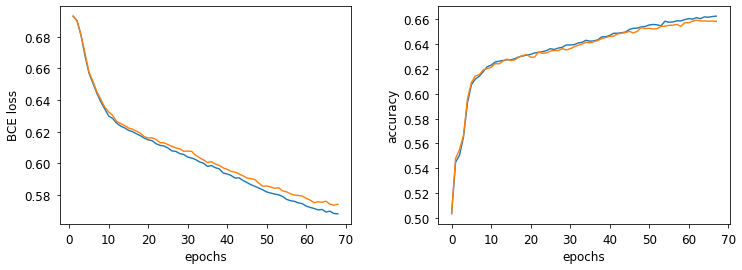

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=0.3)

ax[0].plot(np.arange(1, len(loss_train_gcn)+1), loss_train_gcn)
ax[0].plot(np.arange(1, len(loss_val_gcn)+1), loss_val_gcn)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('BCE loss')
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_ylim([np.min(loss_history), np.max(loss_history)])

ax[1].plot(acc_train_gcn)
ax[1].plot(acc_val_gcn)
#ax[1].plot(ap_history, label='AP')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
#ax[1].set_xscale('log')
#ax[1].legend()

#plt.savefig("figures/node_prediction_gcn.pdf", bbox_inches='tight')
plt.show()

### GraphSAGE

In [29]:
h = 256
print('number of hidden units = %i' %h)

model = SAGE(data.x.shape[1], h, num_classes).to(device)
model.set_aggr('mean')
print('number of trainable parameters %i' %model_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

number of hidden units = 256
number of trainable parameters 335618


In [30]:
def train():
    model.train()

    total_loss = total_examples = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        batch_size = out[batch.train_mask].shape[0]
        loss = F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_size
        total_examples += batch_size
    return total_loss / total_examples

@torch.no_grad()
def evaluator_train():
    model.eval()
    
    y_target = torch.empty(0)
    y_pred = torch.empty(0)
    total_loss = total_examples = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        batch_size = out[batch.train_mask].shape[0]
        total_examples += batch_size
        total_loss += F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask]).item() * batch_size
        
        y_target = torch.cat((y_target, 1.0 * batch.y[batch.train_mask].cpu()), 0)
        y_pred = torch.cat((y_pred, 1.0 * torch.argmax(nn.Softmax()(out[batch.train_mask]), axis=1).cpu()), 0)
        
    y_target = y_target.numpy()
    y_pred = y_pred.numpy()
    
    return total_loss/total_examples, y_target, y_pred

@torch.no_grad()
def evaluator_val():
    model.eval()
    
    y_target = torch.empty(0)
    y_pred = torch.empty(0)
    total_loss = total_examples = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        batch_size = out[batch.val_mask].shape[0]
        total_examples += batch_size
        total_loss += F.nll_loss(out[batch.val_mask], batch.y[batch.val_mask]).item() * batch_size
        
        y_target = torch.cat((y_target, 1.0 * batch.y[batch.val_mask].cpu()), 0)
        y_pred = torch.cat((y_pred, 1.0 * torch.argmax(nn.Softmax()(out[batch.val_mask]), axis=1).cpu()), 0)

    y_target = y_target.numpy()
    y_pred = y_pred.numpy()
    
    return total_loss/total_examples, y_target, y_pred

In [31]:
loss_train_sage = []
acc_train_sage = []
auc_train_sage = []
ap_train_sage = []
loss_val_sage = []
acc_val_sage = []
auc_val_sage = []
ap_val_sage = []

for epoch in range(n_epochs+1):

    # evaluate on both train and val sets
    loss_train, y_target_train, y_pred_train = evaluator_train()
    loss_val, y_target_val, y_pred_val = evaluator_val()
    
    if epoch == 0:
        print('number of training examples: %i, number of validation examples: %i' %(len(y_pred_train), len(y_pred_val)))
    
    # compute the accuracy, average precision, AUC
    acc_train = np.mean(y_pred_train == y_target_train)
    auc_train = roc_auc_score(y_target_train, y_pred_train)
    ap_train = average_precision_score(y_target_train, y_pred_train)
    roc_train = roc_curve(y_target_train, y_pred_train)

    acc_val = np.mean(y_pred_val == y_target_val)
    auc_val = roc_auc_score(y_target_val, y_pred_val)
    ap_val = average_precision_score(y_target_val, y_pred_val)
    roc_val = roc_curve(y_target_val, y_pred_val)

    # record the results
    loss_train_sage.append(loss_train)
    acc_train_sage.append(acc_train)
    auc_train_sage.append(auc_train)
    ap_train_sage.append(ap_train)
    
    loss_val_sage.append(loss_val)
    acc_val_sage.append(acc_val)
    auc_val_sage.append(auc_val)
    ap_val_sage.append(ap_val)

    # print results
    print('epoch: %i||train loss: %.4f||val loss: %.4f||train acc: %.4f||val acc: %.4f||train auc: %.4f||val auc: %.4f' \
          % (epoch, loss_train, loss_val, acc_train, acc_val, auc_train, auc_val))
    
    # train
    if epoch != n_epochs:
        loss_train = train()


number of training examples: 943971, number of validation examples: 237165
epoch: 0||train loss: 0.6929||val loss: 0.6931||train acc: 0.5024||val acc: 0.5020||train auc: 0.5046||val auc: 0.5041
epoch: 1||train loss: 0.6555||val loss: 0.6557||train acc: 0.6516||val acc: 0.6517||train auc: 0.6493||val auc: 0.6488
epoch: 2||train loss: 0.5403||val loss: 0.5403||train acc: 0.7553||val acc: 0.7555||train auc: 0.7542||val auc: 0.7539
epoch: 3||train loss: 0.4598||val loss: 0.4582||train acc: 0.7858||val acc: 0.7878||train auc: 0.7852||val auc: 0.7869
epoch: 4||train loss: 0.4028||val loss: 0.4025||train acc: 0.8290||val acc: 0.8302||train auc: 0.8284||val auc: 0.8295
epoch: 5||train loss: 0.3491||val loss: 0.3477||train acc: 0.8480||val acc: 0.8483||train auc: 0.8476||val auc: 0.8479
epoch: 6||train loss: 0.3052||val loss: 0.3036||train acc: 0.8654||val acc: 0.8661||train auc: 0.8648||val auc: 0.8654
epoch: 7||train loss: 0.2694||val loss: 0.2670||train acc: 0.8814||val acc: 0.8827||train au

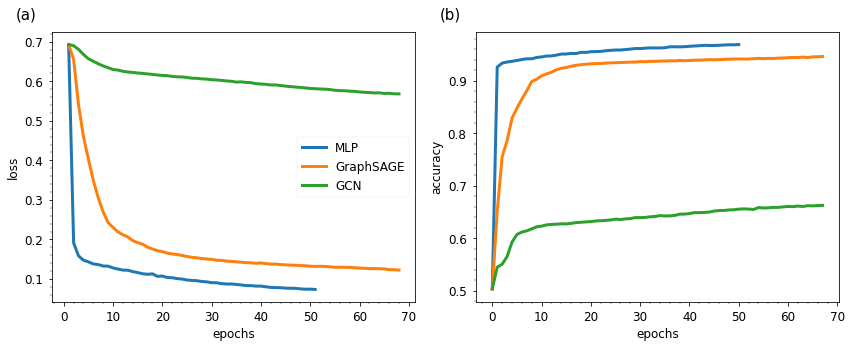

In [71]:
import matplotlib.ticker as tck
lw = 3

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.3)

ax[0].text(-0.1, 1.05, '(a)', transform=ax[0].transAxes, size=15)
ax[1].text(-0.1, 1.05, '(b)', transform=ax[1].transAxes, size=15)

ax[0].plot(np.arange(1, len(loss_train_mlp)+1), loss_train_mlp, label='MLP', linewidth=lw)
ax[0].plot(np.arange(1, len(loss_train_sage)+1), loss_train_sage, label='GraphSAGE', linewidth=lw)
ax[0].plot(np.arange(1, len(loss_train_gcn)+1), loss_train_gcn, label='GCN', linewidth=lw)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(tck.AutoMinorLocator())

ax[1].plot(acc_train_mlp, linewidth=lw, label='MLP')
ax[1].plot(acc_train_sage, linewidth=lw, label='GraphSAGE')
ax[1].plot(acc_train_gcn, linewidth=lw, label='GCN')
ax[1].xaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1].yaxis.set_minor_locator(tck.AutoMinorLocator())
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig("figures/node_prediction_results.pdf", bbox_inches='tight')
plt.show()